In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from user import User

from tensorflow import keras
from sklearn.model_selection import train_test_split
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:

def read_file(file):
    "return 2d df after imputing with 0s"

    # read data
    df = pd.read_csv(file)

    # replace the question marks with NaN and then change data type to float 32
    df.replace(["?"],np.nan, inplace = True)
    df = df.astype(np.float32)

    # imputation
    df.fillna(0,inplace=True) # fill nulls with 0
    return df
def split_dataframe(df, for_user = None, val_size = 0.25, test_size =  0.75, seed = 1):
    # split into train, validation and test data using sklearn and return dfs for each
    if for_user!=None:
        df = df[df["User"] == for_user]
    if df.shape[0] == 0:
        # if no data for the user, then return 9 empty dfs as per the api
        # print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return (df for _ in range(9))

    df_train, df_test = train_test_split(df,
                                         test_size = test_size,
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train,
                                         test_size = val_size,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)

    return df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user, \
        df_train, df_train_class, df_train_user

In [13]:
def init_model(init_seed=1):
    model = keras.Sequential([
        keras.layers.Flatten(),
#         keras.layers.Dense(2048, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
#         keras.layers.Dense(1024, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(128, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model
def init_users(df):
    print("Initialising User instances...")
    users = dict()
    num_users = df["User"].nunique()

    for user_id in range(-1,num_users):

        i = user_id

        if user_id < 0: # for global user with id -1
            user_id = None

        df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user,\
        df_train, df_train_class, df_train_user = split_dataframe(df, for_user=user_id)

        user_id = i

        if df_train.shape[0]==0:
            print(f"User {user_id} has no data, no instance created...")
            continue

        model = init_model(init_seed = 1)

        users[user_id] = User(id=user_id,
                          model = model,
                          train_class = df_train_class,
                          train_data = df_train,
                          val_class = df_val_class,
                          val_data = df_val,
                          test_class = df_test_class,
                          test_data = df_test)

    global_user = users.pop(-1)

    print(f"{len(users.keys())} User instances and a global user created!")
    return users, global_user

In [11]:
def train_model(user, epochs = 16,
                weights = None,
                verbose_fit = False, verbose_evaluate = False):
    # https://www.tensorflow.org/beta/tutorials/keras/basic_classification
    # same seed value for consistency sake, across all trainings too
    """
    trains the model for the user
    and updates the weights and history attribute for the user too
    """

    train_data = user.get_train_data()
    train_class = user.get_train_class()
    val_data = user.get_val_data()
    val_class = user.get_val_class()
    model = user.get_model()

    if weights != None: # if provided, update model weights
        model.set_weights(weights)

    e = evaluate_user(user, verbose = verbose_evaluate)
    user.add_pre_fit_evaluation(e)


    history = model.fit(
        train_data,
        train_class,
        epochs = epochs,
        verbose = verbose_fit,
        # batch_size = 2**8, #4k
        # use_multiprocessing = True,
        validation_data = (val_data, val_class)
    )

    e = evaluate_user(user, verbose = verbose_evaluate)
    user.add_post_fit_evaluation(e)

    # update user data
    user.set_history(history)

    return


def train_users(users, epochs,
                new_weights = None,
                train_model_verbose_evaluate = 0,
                train_model_verbose_fit = False,
                verbose = True):
    for user in users.values():
        # if user.get_id() < 0:
        #     continue

        if verbose:
            message = f"User {user.get_id()} being trained on the model..."
            print(message)

        train_model(
            user,
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            verbose_fit = train_model_verbose_fit,
            verbose_evaluate = train_model_verbose_evaluate
        )

        if verbose:
            message = f"User {user.get_id()} done!"
            print(message)

    return



def train_fed(epochs, rounds, users,
              verbose = True,
              train_user_verbose = False,
              train_model_verbose_evaluate = False,
              train_model_verbose_fit = False,
              averaging_method = 'all',
             averaging_pre = False,
             averaging_post = False,
             averaging_loss = False,
             averaging_accuracy = False):

    new_weights = None
    for i in range(rounds):
        if verbose:
            message = f"{'*'*32} {i:^4} {'*'*32} "
            print(message)

        train_users(users, epochs = EPOCHS,
                   new_weights = new_weights,
                   verbose = train_user_verbose,
                   train_model_verbose_evaluate = train_model_verbose_evaluate,
                   train_model_verbose_fit = train_model_verbose_fit)
        new_weights = average_weights(users, method = averaging_method, 
                                      pre = averaging_pre,
                                      post = averaging_post, 
                                      accuracy = averaging_accuracy, 
                                      loss = averaging_loss)
#         print(new_weights)
        if verbose:
            message = f"{'*'*32} {'DONE':^4} {'*'*32}"
            print(message)
    return


In [6]:
def average_weights(users, method = 'all', 
                    ignore_first_n = 0, 
                    loss = False, 
                    accuracy = False, 
                    post = False,
                    pre = False):
    new_weights = []
    layer_indices_count = len(users[0].get_weights())
    if pre == post or loss==accuracy:
        print("Please select one of pre or post and loss or accuracy")
        return None
    
    latest_user_metric = \
            lambda u, pr, po, acc, lo: u.get_latest_accuracy(pre = pr, post = po) if acc \
                    else (u.get_latest_loss(pre = pr, post = po) if lo else None)
        
    if method == "std_dev":
            
        latest_metrics = []
        for user in users.values():
#             print(user.get_latest_accuracy(pre = pre, post = post))
            value = latest_user_metric(user,pre,post,accuracy,loss)
            latest_metrics.append(value)
        
        latest_metrics = np.asarray(latest_metrics)
        std_dev = latest_metrics.std()
        avg = latest_metrics.mean()
    
    
    users_used = set()

    # sum of the accuracies, as thatll be what you divide by, think
    # this is for weighted average division
    acc_sum = 0
    
    #create a numpy array of 0s
    new_weights = np.asarray(users[0].get_weights())
    for i in new_weights:
        i[i==i] = 0
        
    for user in users.values():
        if method == "all":
            user_weights = np.asarray(user.get_weights())
            users_used.add(user.get_id())
            new_weights += user_weights #nested array of [weights] and [biases]
        
        elif method == "std_dev":
            curr_metric = latest_user_metric(user,pre,post,accuracy,loss) 
            if curr_metric >= (avg-std_dev):
                user_weights = np.asarray(user.get_weights())
                users_used.add(user.get_id())
                new_weights += user_weights #nested array of [weights] and [biases]
            else:
                print(f"user {user.get_id()}: {curr_metric} < {avg-std_dev}")
#                 continue
        
        elif method == "weighted_avg":
            user_weights = np.asarray(user.get_weights())
            users_used.add(user.get_id())

            curr_metric = latest_user_metric(user,pre,post,accuracy,loss) 
            acc_sum += curr_metric
            
            user_weights = user_weights * curr_metric # weighted average

            new_weights += user_weights #nested array of [weights] and [biases]

    if method == "weighted_avg":
        new_weights = new_weights/acc_sum
    else:
        new_weights = new_weights/len(users_used)

    return new_weights.tolist()

def num_users(users):
    return len(users.values())

def evaluate_user(user, verbose = True):
    "prints the loss and accuracy for the given User instance"
    test_data = user.get_test_data()
    test_class = user.get_test_class()
    model = user.get_model()
    evaluation = model.evaluate(test_data,
                                test_class,
                                verbose = verbose)
    return evaluation

In [7]:
def draw_graphs(user, loss = True, accuracy = True):
    # this is from the book 74,75
    # history = model.fit(...)
    history = user.get_history()
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    plt.xlabel('Epochs')

    if loss:
        plt.plot(epochs, acc_values, 'b', label='Training acc')
        plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.clf()
    if accuracy:
        plt.plot(epochs, loss_values, 'b', label='Training loss')
        plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()


def _plot_with_fill(df, x_axis, position, metric, color, std_dev_fill, min_max_fill):
        position_label = f"{position}-fit"
        position_df = df[df["Position"]==f"{position}"]
        avg = position_df["Average"]
        plt.plot(x_axis, avg, color, linewidth = 1, label = f"{position_label} {metric}")
        
        if std_dev_fill:
            std_dev = position_df["Standard Deviation"]
            plt.fill_between(x_axis, 
                             avg - std_dev, 
                             avg + std_dev, 
                             alpha=0.08, color = color)
        elif min_max_fill:
            mini = position_df["Minimum"]
            maxi = position_df["Maximum"]
            plt.fill_between(x_axis,
                             maxi, 
                             avg, 
                             alpha=0.08, color = color)
            plt.fill_between(x_axis,
                             avg, 
                             mini, 
                             alpha=0.08, color = color)

def _userwise_data(user, 
                     ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      pre= pre,
                                     post = post)
    avg = np.average(user_data)
    std_dev = np.std(user_data)
    mini = np.amin(user_data)
    maxi = np.amax(user_data)
    final = user_data[-1]
    return (user_data,avg, std_dev, mini, maxi,final)        

def userwise_stats_df(users,ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    cols = ["Position", "User", "Average", "Standard Deviation", "Minimum", "Maximum", "Final Value"]
    df = pd.DataFrame(columns = cols)
    df_index = 0    
    for i, user in users.items():
        if post:
            user_data,avg, std_dev, mini, maxi,final = \
                   _userwise_data(user, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post)

            df.loc[df_index] = ["Post", i, avg, std_dev, mini, maxi, final]
            df_index +=1
        if pre:
            user_data,avg, std_dev, mini, maxi,final = \
                   _userwise_data(user, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          pre = pre)       
            df.loc[df_index] = ["Pre", i, avg, std_dev, mini, maxi, final]

            df_index +=1 
    return df

def avg_user_stats(users, std_dev_fill = False, min_max_fill = False,
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0, save_as = None, final_values = False):
    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    df = userwise_stats_df(users, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post , pre = pre)
            
    user_ids = list(users.keys())
    # plot here and then fill here
    
    if pre:
        if final_values:
            _print_finals(df, position = "Pre", metric= metric)
            
        _plot_with_fill(df, x_axis = user_ids,
                        position = "Pre",
                        metric = metric,
                        color = "r",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)
    
    if post:
        if final_values:
            _print_finals(df, position = "Post", metric = metric)
        
        _plot_with_fill(df, x_axis = user_ids,
                        position = "Post",
                        metric = metric,
                        color = "b",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)

    
    plt.xlabel("Users")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per User with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    return df


def _print_finals(df, position, metric):
    finals =df[df["Position"]==f"{position}"]
    finals = finals[["User", "Final Value"]]
    print(f"Final {metric} for {position}-fit data")
    print(finals)
    print(f"Averaged: {finals['Final Value'].mean()}\n")


def _roundwise_data(users, 
                     ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    user_data = []
    for i, user in users.items():
        user_data_temp = user.get_data(ignore_first_n = ignore_first_n, 
                                  loss = loss, 
                                  accuracy = accuracy, 
                                  post = post, pre = pre)
        user_data.append(user_data_temp)
    user_data = np.asarray(user_data)
    rounds = len(user_data[0])
    avg = np.average(user_data, axis = 0)
    std_dev = np.std(user_data,  axis = 0)
    mini = np.amin(user_data, axis = 0)
    maxi = np.amax(user_data, axis = 0)
    return (user_data,rounds,avg, std_dev, mini, maxi)        

def roundwise_stats_df(users,ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    cols = ["Position", "Round", "Average", "Standard Deviation", "Minimum", "Maximum"]
    df = pd.DataFrame(columns = cols)
        
    # collect user metric values into a numpy array
    # of shape (number of users, number of rounds)
    # and calculate roundwise average across all users returning an
    # array for the average of the round across all users
    if post:
        user_data_post,rounds,post_avg, post_std_dev, post_mini, post_maxi = \
                          _roundwise_data(users,
                          ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          post = post)
    if pre:
        user_data_pre,rounds,pre_avg, pre_std_dev, pre_mini, pre_maxi = \
                          _roundwise_data(users,
                          ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          pre = pre)
        
    # the arrays consisting of averages for all rounds, across n users
    # is then put into a dataframe for roundwise stats required for plotting
    
    rounds = [i+ignore_first_n for i in range(rounds)]
    df_index = 0
    for rnd in rounds:
        rnd -= ignore_first_n
        if pre:
            df.loc[df_index] = ["Pre", rnd+ignore_first_n, 
                                pre_avg[rnd], pre_std_dev[rnd], 
                                pre_mini[rnd], pre_maxi[rnd]]
            df_index +=1
        
        if post:
            df.loc[df_index] = ["Post", rnd+ignore_first_n, 
                                post_avg[rnd], post_std_dev[rnd], 
                                post_mini[rnd], post_maxi[rnd]]
            df_index +=1    
    return (df, rounds)


def avg_round_stats(users, std_dev_fill = False, min_max_fill = False,
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0, save_as = None, final_values = False):
    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    df, rounds = roundwise_stats_df(users, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post , pre = pre)
    # plot here and then fill here
    if pre:
        if final_values:
            print(f"Final values for Pre-fit {metric}")
            finals = df[df["Position"]=="Pre"].iloc[-1]
            print(finals)

        _plot_with_fill(df, x_axis = rounds,
                        position = "Pre",
                        metric = metric,
                        color = "r",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)
    
    if post:
        if final_values:
            print(f"Final values for Post-fit {metric}")
            finals = df[df["Position"]=="Post"].iloc[-1]
            print(finals,end="\n\n")
        _plot_with_fill(df, x_axis = rounds,
                        position = "Post",
                        metric = metric,
                        color = "b",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)

    
    
    plt.xlabel("Rounds")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per Round with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    return df


In [14]:
#### algorithm:
df = read_file("../dataset/allUsers.lcl.csv")
df_unshuffled = df
# shuffle the records
df = df.sample(frac = 1)

DEVICE = '/gpu:0'
ROUNDS = 32
EPOCHS = 16 # 16 is good

# start = time.time()

with tf.device(DEVICE):
    
    users_weighted_avg, global_user = init_users(df) # return a dictionary of users with data
    train_fed(users = users_weighted_avg, rounds = ROUNDS,
              epochs = EPOCHS,
              train_user_verbose = False,
              train_model_verbose_evaluate = False,
              train_model_verbose_fit = False,
              averaging_method = 'weighted_avg',
             averaging_post = True,
             averaging_accuracy = True)
    
    users_std_dev, global_user = init_users(df) # return a dictionary of users with data
    train_fed(users = users_std_dev, rounds = ROUNDS,
              epochs = EPOCHS,
              train_user_verbose = False,
              train_model_verbose_evaluate = False,
              train_model_verbose_fit = False,
              averaging_method = 'std_dev',
             averaging_post = True,
             averaging_accuracy = True)
    
    users_all, global_user = init_users(df) # return a dictionary of users with data
    train_fed(users = users_all, rounds = ROUNDS,
              epochs = EPOCHS,
              train_user_verbose = False,
              train_model_verbose_evaluate = False,
              train_model_verbose_fit = False,
              averaging_method = 'all',
             averaging_post = True,
             averaging_accuracy = True)
    


#     inter = time.time()

#     users, global_user = init_users(df) # return a dictionary of users with data

#     print("Global user training and validation")
#     train_model(global_user,
#        epochs = EPOCHS*ROUNDS,
#        verbose_fit = True,
#        verbose_evaluate = True,
#     )
#     draw_graphs(global_user)
    
#     done = time.time()


Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ******************************** 


ResourceExhaustedError: OOM when allocating tensor with shape[128,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_43/dense_200/kernel/Initializer/random_uniform/RandomUniform (defined at <ipython-input-6-963a883d4021>:85) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'sequential_43/dense_200/kernel/Initializer/random_uniform/RandomUniform':
  File "c:\program files\python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\program files\python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\program files\python37\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\program files\python37\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\program files\python37\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\program files\python37\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "c:\program files\python37\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "c:\program files\python37\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "c:\program files\python37\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\program files\python37\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\program files\python37\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\program files\python37\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "c:\program files\python37\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "c:\program files\python37\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\program files\python37\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\program files\python37\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\program files\python37\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\program files\python37\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "c:\program files\python37\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\program files\python37\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\program files\python37\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "c:\program files\python37\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-a6af2f20040d>", line 23, in <module>
    averaging_accuracy = True)
  File "<ipython-input-11-ea03c327b877>", line 93, in train_fed
    train_model_verbose_fit = train_model_verbose_fit)
  File "<ipython-input-11-ea03c327b877>", line 61, in train_users
    verbose_evaluate = train_model_verbose_evaluate
  File "<ipython-input-11-ea03c327b877>", line 20, in train_model
    e = evaluate_user(user, verbose = verbose_evaluate)
  File "<ipython-input-6-963a883d4021>", line 85, in evaluate_user
    verbose = verbose)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 941, in evaluate
    steps=steps)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 2558, in _standardize_user_data
    self._set_inputs(cast_inputs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 2776, in _set_inputs
    outputs = self(inputs, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 634, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 261, in call
    outputs = layer(inputs, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\layers\core.py", line 1017, in build
    trainable=True)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\training\tracking\base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 155, in make_variable
    shape=variable_shape if variable_shape.rank else None)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    shape=shape)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 460, in __init__
    shape=shape)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 604, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 135, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py", line 533, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\random_ops.py", line 247, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 859, in random_uniform
    name=name)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "c:\program files\python37\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
ignore_first_n = 0
final_values = True
# df_avg_user_stats_loss = avg_user_stats(users, 
#                                         ignore_first_n = ignore_first_n, 
#                                         std_dev_fill = True, 
#                                         loss = True)

# df_avg_round_stats_loss = avg_round_stats(users,
#                                           ignore_first_n = ignore_first_n,
#                                           std_dev_fill = True,
#                                           loss = True)
# std_dev_fill
# min_max_fill

print("For all")

df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)

print("For acc > avg-std")
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)

df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                     min_max_fill = True, 
                                         accuracy = True,
                                        final_values = final_values)


print("For weight * weighted_avg")

df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)


# print(df_avg_round_stats_acc)

For all
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.932371
3     1     0.877897
5     2     0.854062
7     4     0.505263
9     5     0.906764
11    6     0.965276
13    7     0.479675
15    8     0.937365
17    9     0.925170
19   10     0.990529
21   11     0.979491
23   12     0.979720
25   13     0.993593
Averaged: 0.8713212357117579

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.981582
2     1     0.984172
4     2     0.974003
6     4     0.792982
8     5     0.991382
10    6     0.998782
12    7     0.623306
14    8     0.982580
16    9     0.994898
18   10     0.993593
20   11     0.994707
22   12     0.993697
24   13     0.998474
Averaged: 0.9464737543692956



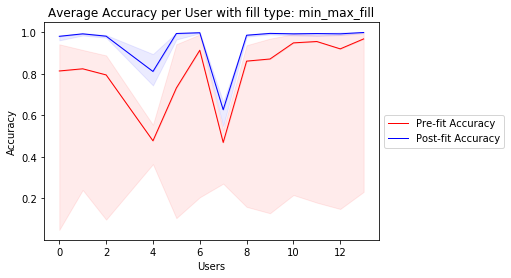

Final values for Pre-fit Accuracy
Position                   Pre
Round                       99
Average               0.871321
Standard Deviation    0.166736
Minimum               0.479675
Maximum               0.993593
Name: 198, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                       99
Average               0.946474
Standard Deviation    0.107163
Minimum               0.623306
Maximum               0.998782
Name: 199, dtype: object



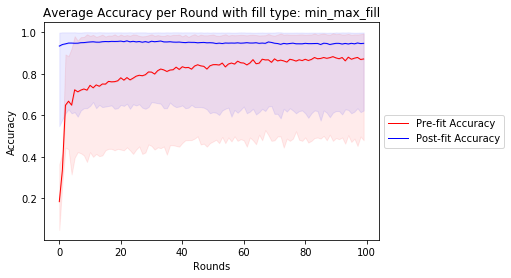

For acc > avg-std
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.913806
3     1     0.932448
5     2     0.875037
7     4     0.428070
9     5     0.930791
11    6     0.982638
13    7     0.441734
15    8     0.938931
17    9     0.930952
19   10     0.962813
21   11     0.968574
23   12     0.943820
25   13     0.992830
Averaged: 0.8648035136552957

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.982319
2     1     0.988977
4     2     0.969572
6     4     0.807018
8     5     0.993732
10    6     0.998172
12    7     0.593496
14    8     0.985712
16    9     0.994218
18   10     0.991226
20   11     0.994542
22   12     0.998356
24   13     0.998322
Averaged: 0.9458199785305903



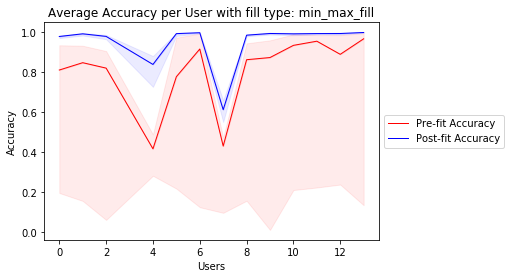

Final values for Pre-fit Accuracy
Position                   Pre
Round                       99
Average               0.864804
Standard Deviation    0.185622
Minimum                0.42807
Maximum                0.99283
Name: 198, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                       99
Average                0.94582
Standard Deviation    0.113028
Minimum               0.593496
Maximum               0.998356
Name: 199, dtype: object



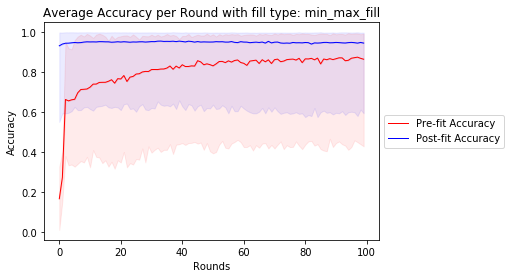

For weight * weighted_avg
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.949020
3     1     0.914924
5     2     0.864993
7     4     0.519298
9     5     0.961609
11    6     0.982029
13    7     0.487805
15    8     0.935017
17    9     0.950680
19   10     0.988301
21   11     0.968409
23   12     0.984105
25   13     0.991915
Averaged: 0.8844694953698379

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.977457
2     1     0.987281
4     2     0.971935
6     4     0.782456
8     5     0.991643
10    6     0.996040
12    7     0.577236
14    8     0.986886
16    9     0.995238
18   10     0.991504
20   11     0.992722
22   12     0.987942
24   13     0.996491
Averaged: 0.94114089012146



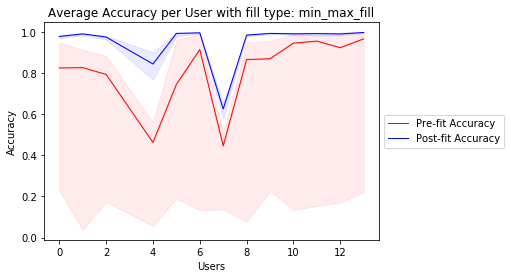

Final values for Pre-fit Accuracy
Position                   Pre
Round                       99
Average               0.884469
Standard Deviation    0.165918
Minimum               0.487805
Maximum               0.991915
Name: 198, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                       99
Average               0.941141
Standard Deviation    0.118659
Minimum               0.577236
Maximum               0.996491
Name: 199, dtype: object



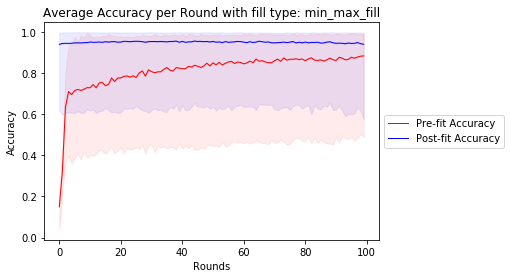

<Figure size 432x288 with 0 Axes>

In [33]:
ignore_first_n = 0
final_values = True
# df_avg_user_stats_loss = avg_user_stats(users, 
#                                         ignore_first_n = ignore_first_n, 
#                                         std_dev_fill = True, 
#                                         loss = True)

# df_avg_round_stats_loss = avg_round_stats(users,
#                                           ignore_first_n = ignore_first_n,
#                                           std_dev_fill = True,
#                                           loss = True)
# std_dev_fill
# min_max_fill

print("For all")

df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values,
                                      save_as = "user_all")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values,
                                         save_as = "round_all")


print("For acc > avg-std")
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                         final_values = final_values,
                                         save_as = "user_acc_more_(avg-std)")

df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                     min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values,
                                         save_as = "round_acc_more_(avg-std)")


print("For weight * weighted_avg")

df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values,
                                         save_as = "user_weighted_avg")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values,
                                         save_as = "round_weighted_avg")


# print(df_avg_round_stats_acc)